## Import jednotlivých balíčků
 * Navíc budeme akorát potřebovat balíček wordcloud pro pozdější vizualizaci klíčových slov v závěrečných prací.

In [1]:
import numpy as np
import pandas as pd
import sklearn as skit
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # pip install wordcloud

import matplotlib
%matplotlib inline 
matplotlib.style.use('ggplot')

## Stažená data
    * Data pochází z VSFS (Vysoká škola finanční a správní)
    * Data byla stažena za období 2009 až 2017

In [2]:
THESIS_DATA = pd.read_csv('data/thesis.csv')

YEAR_LIST = THESIS_DATA['Rok'].unique().tolist()
YEAR_LIST.sort()
THESIS_TYPES = THESIS_DATA['Typ prace'].unique().tolist()

DIC_DEGREE = {
    'doc.':0,
    'prof.':0,
    'Ph.D.':0,
    'JUDr.':0,
    'RNDr.':0,
    'Paedr.':0,
    'PhDr.':0,
    'MUDr.':0,
    'RSDr.':0,
    'Dr.':0,
    'Mgr.':0,
    'Ing.':0,
    'Bc.':0,
    'MBA.':0,
    'Bez titulu':0
}
print('Stazene roky: ',YEAR_LIST)
print('Vyskytujici se typy praci: ', THESIS_TYPES)

THESIS_DATA.head(3)

Stazene roky:  [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Vyskytujici se typy praci:  ['Bc.', 'Ing.', 'Mgr.', 'Ph.D.']


,Autor,Nazev prace,Studijni program,Typ prace,Rok,Obhajeno,Vedouci,Oponent
0,Bc. David Ábelovský,Přechod z daňové evidence na účetnictví ve vyb...,Řízení podniku a podnikové finance,Bc.,2009,1,Ing. Jitka Hašková,Ing. Petra Holčáková
1,Petra Bartáková,Sociální exkluze a řešení problémů na trhu prá...,Veřejná správa,Bc.,2009,1,PhDr. Jaroslava Kadeřábková,Ing. Michaela Šlégrová
2,Bc. Lenka Adamová,Regionální politika v ČR v letech 2007-2013,Veřejná správa,Bc.,2009,1,PhDr. Jaroslava Kadeřábková,Ing. Michaela Šlégrová


In [3]:
def createYearFrameWithZeros():
    '''
    Generates a data frame representing number of authors in specific year.
    The function generate frame with zero values for 'Autor' column.    
    '''
    global YEAR_LIST
    zeroArray = np.zeros(len(YEAR_LIST), dtype=int).tolist()
    return pd.DataFrame(data ={'Rok':YEAR_LIST, 'Autor':zeroArray})

def createThesisTypeFrame(thesisType='All'):
    '''
    Generates a data frame representing number of authors in specific year.
    '''
    global THESIS_DATA
    if (thesisType == 'All'):
        frame = THESIS_DATA.groupby('Rok').size().to_frame()
    else:
        frame = THESIS_DATA[THESIS_DATA['Typ prace']==thesisType].groupby('Rok').size().to_frame()
    frame.columns=[thesisType]
    
    #When there is no specific thesis type in a specific year, 'frame' will miss a row with the year
    #We add missing row via combining 'frame' and 'zeroframe' which contains all years
    zeroFrame = createYearFrameWithZeros()
    zeroFrame=zeroFrame.set_index('Rok')
    zeroFrame.columns=[thesisType]
        
    result = frame.combine_first(zeroFrame) 
    result[thesisType] = result[thesisType].astype(int)
    return result

def createThesisTypeFrameForAllYears():
    global THESIS_TYPES
    frames = []
    for t in THESIS_TYPES:
        fr = createThesisTypeFrame(t)
        frames.append(fr)
        
    fr = createThesisTypeFrame('All')
    frames.append(fr) 
    concatFrame = pd.concat(frames, axis=1)
    return concatFrame

## Vývoj počtu obhájených prací
 * Staženo bylo přes 12 000 závěrečných prací.
 * Mezi roky 2009-2012 nebyla obhajována žádná Ph.D. práce.
 * Ph.D. práce jsou pouze v řádu jednotek.
 * Od roku 2013 univerzita VSFS produkuje vice inženýrů než bakalářů!
 * Od roku 2011 celkový počet záverečných prací klesá.

,Bc.,Ing.,Mgr.,Ph.D.,All
Rok,,,,,
2009,889,655,13,0,1557
2010,853,648,22,0,1523
2011,868,805,23,0,1696
2012,766,780,11,0,1557
2013,716,799,16,2,1533
2014,699,783,22,4,1508
2015,648,714,17,1,1380
2016,554,603,17,2,1176
2017,541,556,10,2,1109


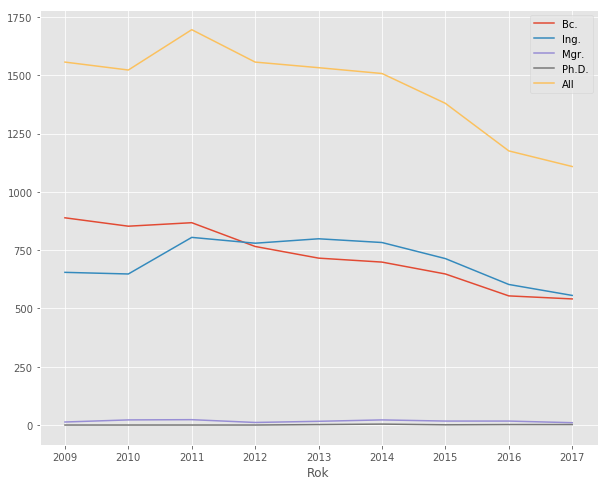

In [4]:
frame = createThesisTypeFrameForAllYears()
display(frame)
frame.plot(figsize=(10, 8))

In [5]:
def generateFramePersonThesis(year, person):
    if (year == 'all'):
        supvisorOrReviewer = THESIS_DATA.groupby(person).size().to_frame()
    else:
        supvisorOrReviewer = THESIS_DATA[THESIS_DATA['Rok']==year].groupby(person).size().to_frame()
    supvisorOrReviewer.columns=[year]
    return supvisorOrReviewer

def topN(n=5, year='all', person='Vedouci'):
    '''
    Generates a frame with the nth biggest number of supervised/reviewed theses for specific year
    '''
    supvisorOrReviewer=generateFramePersonThesis(year, person)
    
    supvisorOrReviewer.columns=[year]
    supvisorOrReviewer.sort_values([year], ascending=False, inplace=True)
    return supvisorOrReviewer.iloc[:n]


def plotNBestPersons(nPersons=10, supvisorOrRev='Vedouci'):
    frame = topN(n=nPersons,year='all', person = supvisorOrRev)
    ax = frame.T.plot.barh(stacked=False,figsize=(10, 8))
    for p in ax.patches:
        ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')

def plotNBestPersonsForSpecificYears(nPersons=3, supvisorOrRev='Vedouci'):
    global YEAR_LIST
    for y in YEAR_LIST:
        frame = topN(n=nPersons,year=y, person=supvisorOrRev)
        ax = frame.T.plot.barh(stacked=True,figsize=(10, 1))
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
        for p in ax.patches:
            ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(6, 10), textcoords='offset points')



## Nejpilnější vedoucí
 * Nejpilnějším vedoucím mezi roky 2009-2017 je doktor pedagogiky Václav Netolický s náskokem 41 prací. Pan Netolický může být ostatním pedagokům skutečně příkladem.

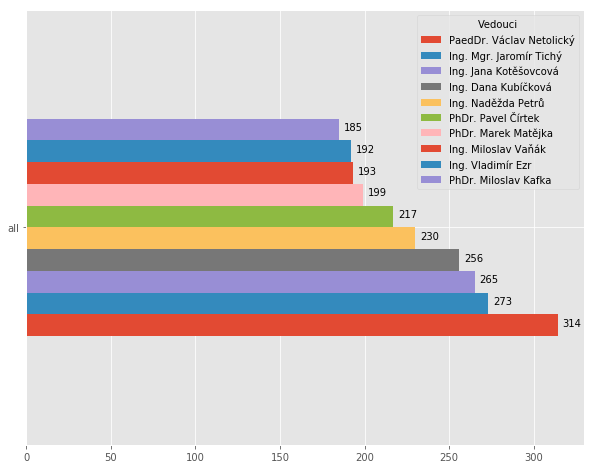

In [6]:
plotNBestPersons(supvisorOrRev='Vedouci')

## Nejpilnější vedoucí v jednotlivých letech

  * Ačkoliv je pan Netolický absolutní přemožitel. Na nejvyšším stupni vítězů se v jednotlivých letech objevil pouze v roce 2011
  * Nejvíce prací vedených za rok měla Ing. Jana Kotěšovcová s celkovým počtem 65 a to v roce 2009. Inženýrka Kotěšovcová se v celkové tabulce umístila třetí.

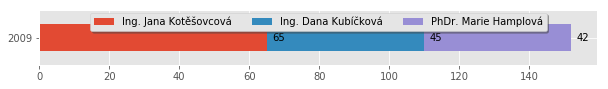

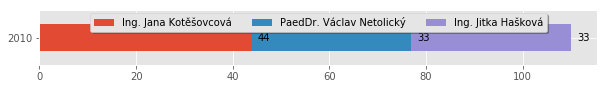

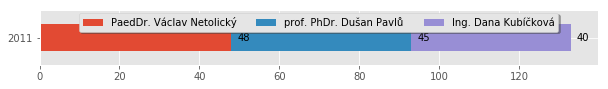

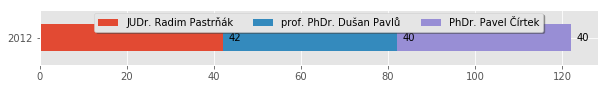

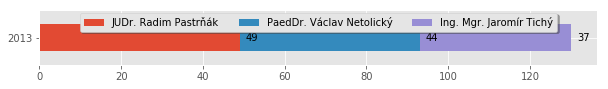

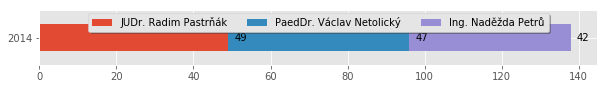

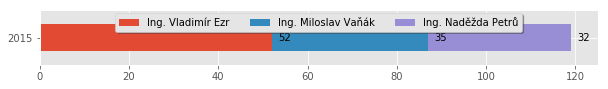

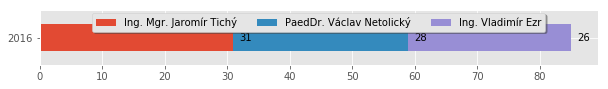

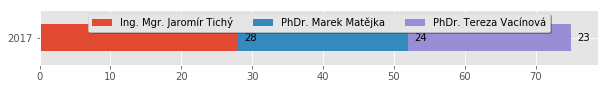

In [7]:
plotNBestPersonsForSpecificYears(supvisorOrRev='Vedouci')

## Nejpilnější oponent

  * Mezi lety 2009-2017 máme absolutní vítěze hned dva.
  * Jaká to náhoda, že rozdíl od další příčky je opět číslo 41. Býti to číslo 42, jistě by se již o náhodu nejednalo!

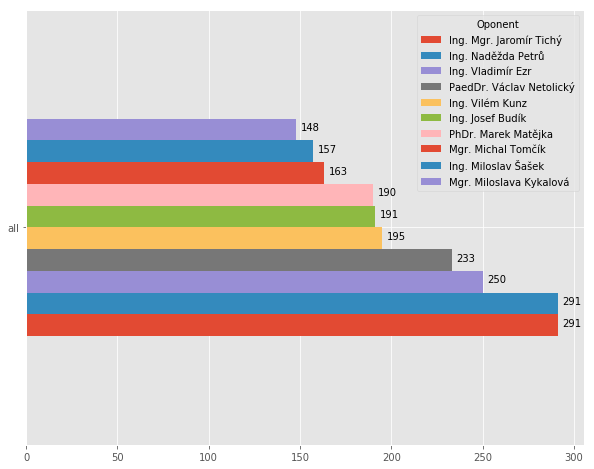

In [8]:
plotNBestPersons(supvisorOrRev='Oponent')

## Nejpilnější oponenti v jednotlivých letech

 * V letech 2009 a 2010 na stupeň vítězů opět dosáhl Paedr. Václav Netolický s počtem oponentur 35 a 58.
 * Objevují se zde řada stejnch osobností jako u nejpilnějších vedoucích.

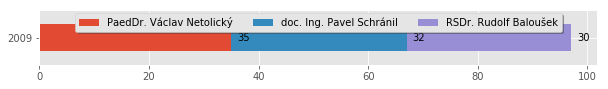

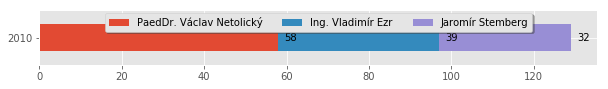

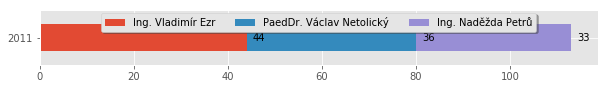

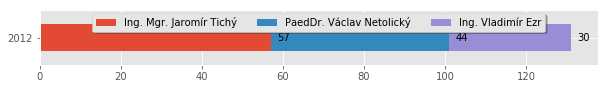

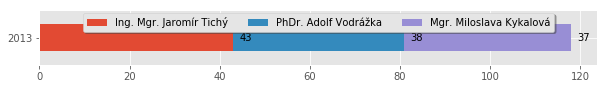

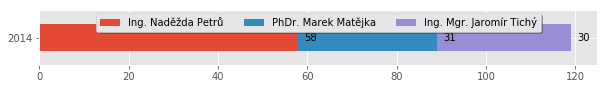

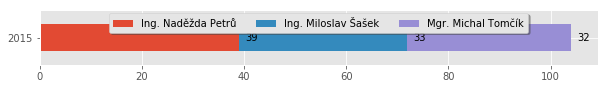

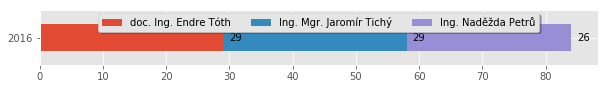

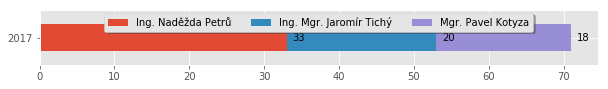

In [9]:
plotNBestPersonsForSpecificYears(supvisorOrRev='Oponent')

In [10]:
 def parseHighestDegree(name):
    partOfName = name.split(' ')
    if ('doc.' in partOfName):
        return 'doc.'
    if ('prof.' in partOfName):
        return 'prof.'
    if ('Ph.D.' in partOfName) or ('Ph. D.' in partOfName):
        return 'Ph.D.'
    if ('PhDr.' in partOfName):
        return 'PhDr.'
    if ('JUDr.' in partOfName):
        return 'JUDr.'
    if ('RNDr.' in partOfName):
        return 'RNDr.'
    if ('PaedDr.' in partOfName):
        return 'Paedr.'
    if ('MUDr.' in partOfName):
        return 'MUDr.'
    if ('RSDr.' in partOfName):
        return 'RSDr.'
    if ('Dr.' in partOfName):
        return 'Dr.'
    if ('Mgr.' in partOfName):
        return 'Mgr.'
    if ('Ing.' in partOfName) or ('ing.' in partOfName):
        return 'Ing.'
    if ('Bc.' in partOfName):
        return 'Bc.'
    if ('MBA.' in partOfName):
        return 'MBA.'
    
    return 'Bez titulu'

def parseAllDegrees(name, degreesCount):
    partOfName = name.split(' ')
    if ('doc.' in partOfName):
        degreesCount['doc.'] += 1
    if ('prof.' in partOfName):
        degreesCount['prof.'] += 1
    if ('Ph.D.' in partOfName) or ('Ph. D.' in partOfName):
        degreesCount['Ph.D.'] += 1
    if ('PhDr.' in partOfName):
        degreesCount['PhDr.'] += 1
    if ('JUDr.' in partOfName):
        degreesCount['JUDr.'] += 1
    if ('RNDr.' in partOfName):
        degreesCount['RNDr.'] += 1
    if ('PaedDr.' in partOfName):
        degreesCount['Paedr.'] += 1
    if ('MUDr.' in partOfName):
        degreesCount['MUDr.'] += 1
    if ('RSDr.' in partOfName):
        degreesCount['RSDr.'] += 1
    if ('Dr.' in partOfName):
        degreesCount['Dr.'] += 1
    if ('Mgr.' in partOfName):
        degreesCount['Mgr.'] += 1
    if ('Ing.' in partOfName) or ('ing.' in partOfName):
        degreesCount['Ing.'] += 1
    if ('Bc.' in partOfName):
        degreesCount['Bc.'] += 1
    if ('MBA.' in partOfName):
        degreesCount['MBA.'] += 1

    if (parseHighestDegree(name) == 'Bez titulu'):
        degreesCount['Bez titulu'] += 1

def createHighestDegreeFrame(personColumn='Vedouci'):
    global DIC_DEGREE, THESIS_DATA
    degreesCount = DIC_DEGREE.copy()
    for name in (THESIS_DATA[personColumn]):
        titul = parseHighestDegree(name)
        degreesCount[titul] += 1
    frame = pd.DataFrame.from_dict(degreesCount, orient='index')
    frame.columns=['Nejvyssi tituly']
    return frame

def createAllDegreeFrame(personColumn='Vedouci'):
    global DIC_DEGREE, THESIS_DATA
    degreesCount = DIC_DEGREE.copy()
    for name in (THESIS_DATA[personColumn]):
        parseAllDegrees(name, degreesCount)
    frame = pd.DataFrame.from_dict(degreesCount, orient='index')
    frame.columns=['Vsechny tituly']
    return frame

def reorderFrame(frame):
    REORDERLIST = ['Dr.','Ph.D.','doc.','MBA.','RSDr.','JUDr.','MUDr.','Mgr.','Ing.','Bc.','prof.','Bez titulu','PhDr.','Paedr.','RNDr.']
    newFrame = frame.reindex(REORDERLIST)
    return newFrame

def plotPieHighestDegree(person='Vedouci'):
    frame = createHighestDegreeFrame(personColumn=person)
    frame = reorderFrame(frame)
    frame = frame[frame['Nejvyssi tituly'] > 0]
    frame.plot.pie(fontsize=15,y='Nejvyssi tituly', figsize=(9,9))
    plt.title(person)

def plotPieAllDegree(person='Vedouci'):
    frame = createAllDegreeFrame(personColumn=person)
    frame = reorderFrame(frame)
    frame = frame[frame['Vsechny tituly'] > 0]
    frame.plot.pie(fontsize=15,y='Vsechny tituly', figsize=(9,9))
    plt.title(person)
    
def plotBarDifferenceBetweenAllHighest(person='Vedouci'):
    fr1 = createAllDegreeFrame(person)
    fr2 = createHighestDegreeFrame(person)
    concatFrame = pd.concat([fr1,fr2], axis=1)
    ax = concatFrame.plot.bar(fontsize=10,figsize=(15,9))
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Rozložení titulů oponentů a vedoucích
Parsování titulů probíhalo dvěma způsoby. Funkce 'parseHighestDegree' brala v úvahu pouze nejvyšší titul osoby (jakoby člověk měl pouze 1 titul). Funkce 'parseAllDegree počítala se všemi tituly konkrétní osoby (pokud člověk měl titul prof. a Ing. započítali jsme do grafu oba dva).
 * Z koláče nám vyplývá, že nejvíce vedoucích má jako nejvyšší titul Ing. Jako druhý nejčastější se objevoval titul doc.
 * Rozložení titulů u oponentů do velké míry kopíruje rozložení titulů vedoucích.

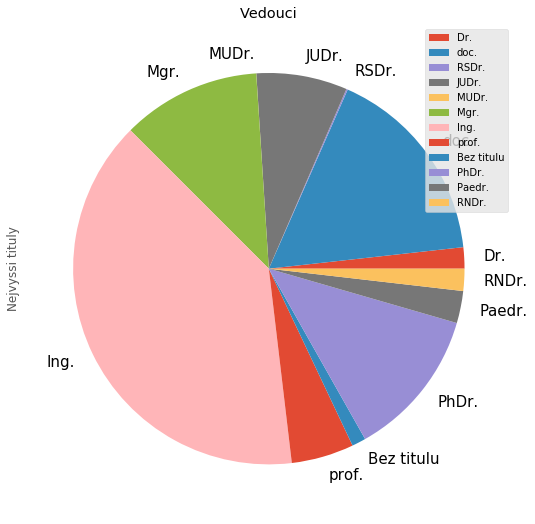

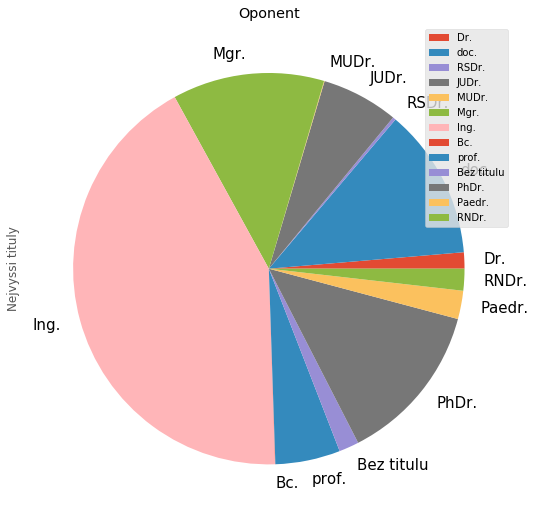

In [11]:
plotPieHighestDegree(person='Vedouci')
plotPieHighestDegree(person='Oponent')

## Rozdíl mezi nejvýše dosaženým titulem vs. všemi dosaženými tituly
Abychom byli spravedliví, následující graf ukazuje, jak moc jsme parsováním pouze jednoho titulu upozadili tituly ostatní.
 * Změnou parsování by nám v předchozích koláčích přibylo cca 2000 inženýrských titulů, 200 doktorů a například 45 bakalářů.
 * Nejvíce jsme parsováním upozadili inženýry

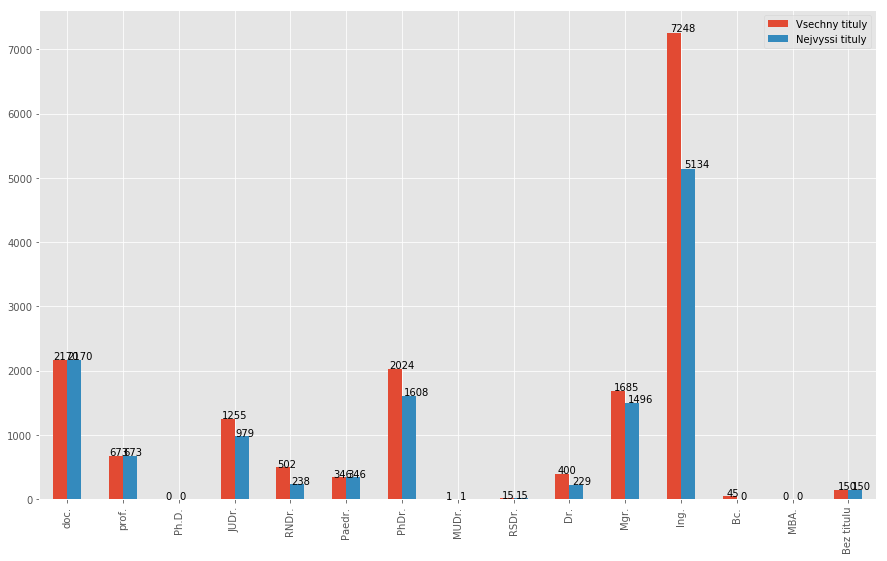

In [12]:
plotBarDifferenceBetweenAllHighest(person='Vedouci')

In [13]:
def containNumber(inputString):
    return any(char.isdigit() for char in inputString)

def containAbandonStr(inputString):
    abandonChar=["\\","...","..",'0', 'jej']
    for c in abandonChar:
        if c in inputString:
            return True
    return False

def stringMeetsConstriction(inputString):
    return ((len(inputString) > 4) and (not containNumber(inputString)) and (not containAbandonStr(inputString)))

def createDicWords():
    global THESIS_DATA
    dicWords={}
    for nameOfThesis in THESIS_DATA['Nazev prace']:
        nameParts = nameOfThesis.split(' ')
        for part in nameParts:
            if stringMeetsConstriction(part):
                part = part.lower()
                if (part in dicWords):
                    dicWords[part] += 1
                else:
                    dicWords[part] = 1
    return dicWords

def countWordsFrame(dicWords):
    frame = pd.DataFrame.from_dict(dicWords, orient='index')
    frame.columns=['Frekvence slov']
    frame.sort_values(['Frekvence slov'], ascending=False, inplace=True)
    return frame

def generateWordClouds(dicWords, minFrequency=10):
    frame = countWordsFrame(dicWords)
    frame = frame[frame['Frekvence slov'] > minFrequency]
    wCloud = WordCloud(width=1200,height=900, max_words=1000,relative_scaling=1,normalize_plurals=False)
    graph = wCloud.generate_from_frequencies(frame['Frekvence slov'])
    
    plt.figure( figsize=(12,9) )
    plt.imshow(graph, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    
def generatePlotBarGraph(dicWords, firstN):
    frame = countWordsFrame(dicWords)
    frame = frame.iloc[:firstN]
    ax = frame.T.plot.barh(stacked=False,figsize=(10, 8))
    for p in ax.patches:
        ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')



## Vizualizace nejčastějších slov v názvech prací
  * Obrázek je poměrně výstižný a netřeba slovního popisu.
  * Nicméně v případě, že se obrázek nezobrazuje nahlédněme alespoň do grafu ukazující četnost jednotlivých slov. Mezi 3 nejčastější slova patří 'řízení' (984 identifikací), 'podniku' (938 identifikací) a 'analýza (829 identifikací).
  * Z nejčastěji po sobě jdoucích prací lze dokonce sestavovat docela hezká témata... řízení, podniku, analýza, komunikace, marketingové, finanční, firmy. Neboli:
    * 'Řízení podniku',
    * 'Analýza komunikace',
    * 'Marketingové a finanční firmy'

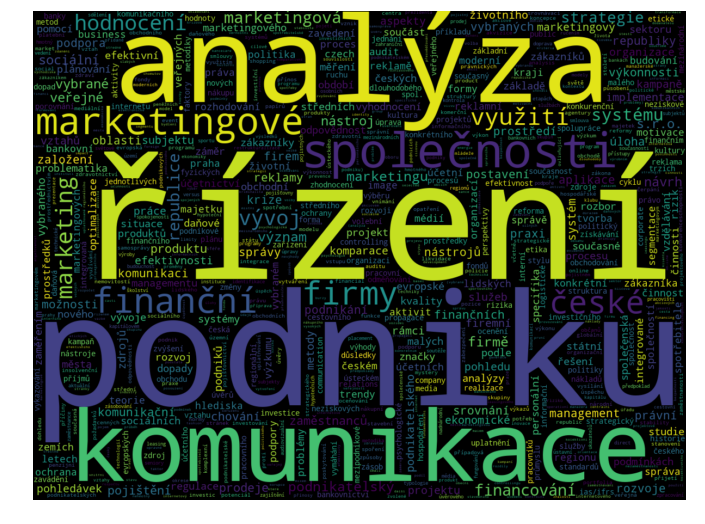

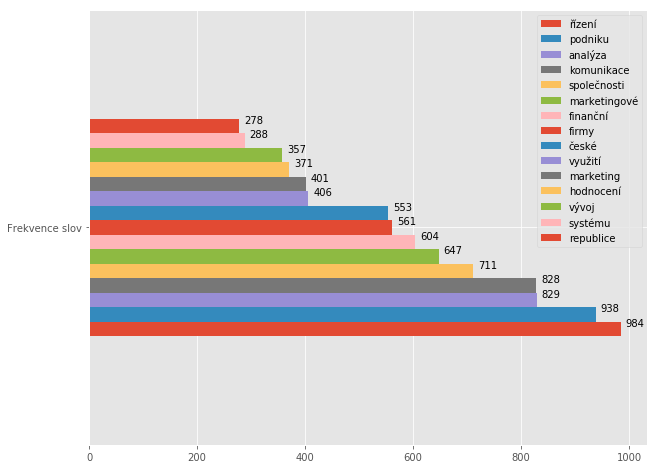

In [14]:
dicWords = createDicWords()
generateWordClouds(dicWords, minFrequency=15)
generatePlotBarGraph(dicWords, 15)

In [15]:
def computeStatistics(title,frame,column):
    print(title)
    print("============================")
    print("Pocet radku:\t", frame.shape[0])
    print("Prumer:\t\t",  frame[column].mean())
    print("Median:\t\t",  frame[column].median())
    print("Maximum:\t", frame[column].max())
    print("Minimum:\t", frame[column].min())
    print("Rozptyl:\t", frame[column].var())
    print("============================")

def distributionOfThesis(year, person, limit):
    frame = generateFramePersonThesis(year, person)
    frame.sort_values([year], ascending=True, inplace=True)
    
    title = 'Za rok: '+str(year)+', pro: '+str(person)
    computeStatistics(title, frame, year)
    frame = frame.groupby(year).size().to_frame()
    frame.index.names = ['pocet praci na starost']
    frame.columns = [('pocet '+person)]
    
    dic={}
    dic['x <= '+str(limit)+' prace']=frame.iloc[:limit]['pocet '+person].sum()
    dic['x > '+str(limit)+' prace']=frame.iloc[limit:]['pocet '+person].sum()
    print(dic)
    
    frameForGraph = pd.DataFrame.from_dict(dic, orient='index')
    frameForGraph.columns = [('pocet '+person)]
    ax = frameForGraph.plot.pie(fontsize=15,y='pocet '+person, figsize=(5,5))
    plt.show()
    
    

## 'Statistický' pohled na data vedoucích a oponentů

  * Za roky 2009-2017 je evidováno 581 vedoucích a 1095 oponujících.
  * Průměrný počet prací na vedoucího je přibližně 22. Nicméně medián rovný 4 a maximum vedených prací 314 naznačuje jistou nerovnoměrnost v datech.
  * Podobné je to i u oponentů... medián je roven 1 (tedy více jak polovina oponentů v letech 2009-2017 oponovala pouze jednou)

Za rok: all, pro: Vedouci
Pocet radku:	 581
Prumer:		 22.44234079173838
Median:		 4.0
Maximum:	 314
Minimum:	 1
Rozptyl:	 1854.6160662353866
{'x <= 1 prace': 200, 'x > 1 prace': 381}


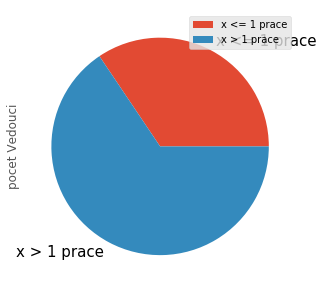

Za rok: all, pro: Oponent
Pocet radku:	 1095
Prumer:		 11.907762557077625
Median:		 1.0
Maximum:	 291
Minimum:	 1
Rozptyl:	 832.4933126309555
{'x <= 1 prace': 595, 'x > 1 prace': 500}


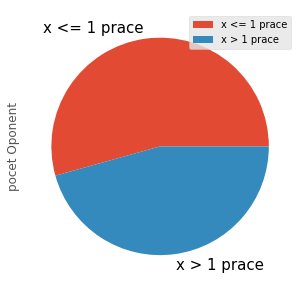

In [16]:
distributionOfThesis('all', 'Vedouci', 1)
distributionOfThesis('all', 'Oponent', 1)

In [17]:
def createSimpleFrameOfSucces():
    '''
    return a sum of succesful, a sum of unsuccesful and
    a sum of unknown thesis
    'unknown' = it is not sure whether thesis was retained right or bad
    '''
    fr = THESIS_DATA.groupby('Obhajeno').size().to_frame()
    fr.sort_values(['Obhajeno'], ascending=True, inplace=True)
    fr = fr.T
    fr.columns = ['nezname','neuspesny','uspesny']
    return fr

def createFrameOfSuccessUnsuccess(person):
    '''
    create frame about how many succesful/unsuccesful theses person 
    has supervised/reviewed
    '''
    global THESIS_DATA
    fr2 = THESIS_DATA[[person, 'Obhajeno']]
    fr3 = pd.get_dummies(data=fr2, columns=['Obhajeno'])
    fr3 = fr3.drop(['Obhajeno_-1'], axis=1)
    fr3 = fr3.groupby([person,'Obhajeno_0','Obhajeno_1']).size().to_frame()
    fr3 = fr3.reset_index()
    fr3.columns = [person, 'Neuspesny', 'Uspesny', 'Pocet']
    fr3.loc[fr3['Uspesny']==1, 'Uspesny'] = fr3.loc[fr3['Uspesny']==1, 'Pocet']
    fr3.loc[fr3['Neuspesny']==1, 'Neuspesny'] = fr3.loc[fr3['Neuspesny']==1, 'Pocet']
    fr3 = fr3.drop(['Pocet'], axis=1)
    fr3 = fr3.groupby(person).sum()[['Neuspesny', 'Uspesny']]
    fr3.sort_values(['Uspesny'], ascending=False, inplace=True)
    return fr3

def findNEvilPerson(person, n):
    '''
    find person who has suprevises/reviewes the most unsuccesful theses
    '''
    fr = createFrameOfSuccessUnsuccess(person)
    fr.sort_values(['Neuspesny'], ascending=False, inplace=True)
    fr = fr.iloc[:n]
    return fr

def displayDistributionOfBadRightThesis():
    fr3 = createSimpleFrameOfSucces()
    display(fr3)
    ax = fr3.drop(['nezname'], axis=1).plot.barh(stacked=True,figsize=(15, 5))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
    for p in ax.patches:
        ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(6, 10), textcoords='offset points')

def displayEvilPerson1(person, n):
    fr3 = findNEvilPerson(person, n)
    ax = fr3.plot.bar(fontsize=15,figsize=(15,9))
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()    

def displayEvilPerson2(person, n):
    fr3 = createFrameOfSuccessUnsuccess(person)
    fr3.sort_values(['Uspesny'], ascending=True, inplace=True)
    fr3 = fr3.loc[ (fr3['Neuspesny'] > 1)]
    fr3 = fr3.iloc[:n]
    ax = fr3.plot.bar(fontsize=15,figsize=(10,9))
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()


## Úspěšnost závěrečných prací
   * Za léta 2009-2017 se nasčítalo 12794 úspěšně obhájených prací.
   * Za léta 2009-2017 studenti ve 202 případech práci neobhájili.
   * Pro 43 prací se nepodařilo tuto informaci zcela zjistit (problém s parsováním, nebo studium stále probíhalo...)
   * Nejkrutějším oponentem se zdá být Ing. Naděžna Petrů s 6 neobhájenými pracemi za období 8 let. Na druhou stranu 284 jiných studentů u inženýrky práci obhájilo
   * Nejkrutějším oponentem s ohledem na poměr mezi úspěšně a neúspěšně obhájenými pracemi je prof. Ing. Mojmír Helísek se 2 neúspěšně a 15 úspěšně oponovanými pracemi. Poznámka: vedoucího IS.VSFS.CZ zjevně nepočítáme.
    

,nezname,neuspesny,uspesny
0,43,202,12794


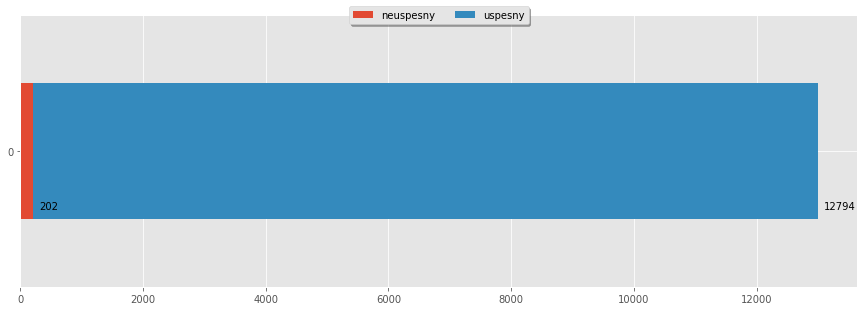

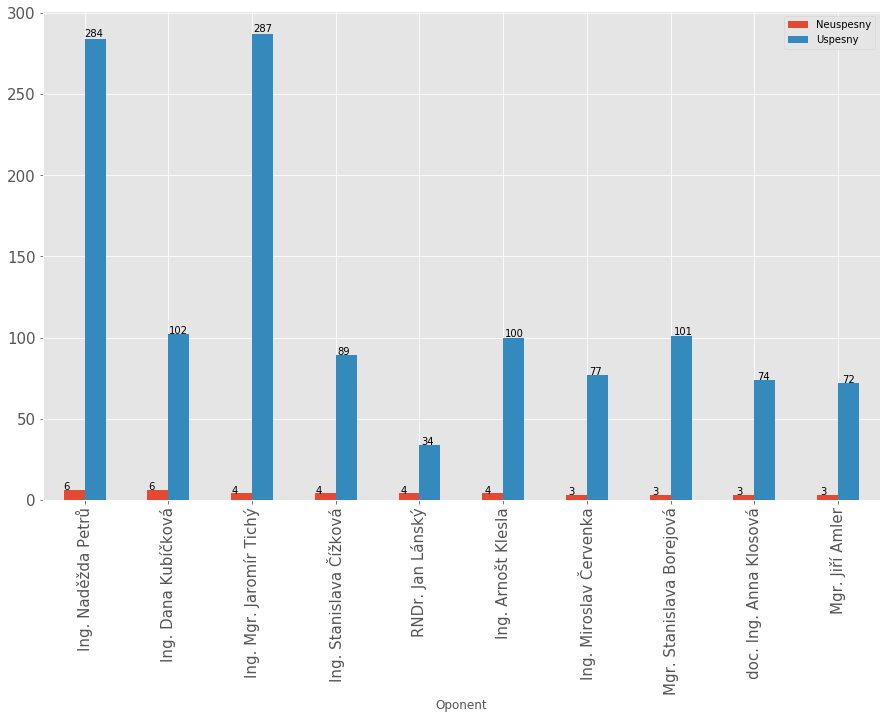

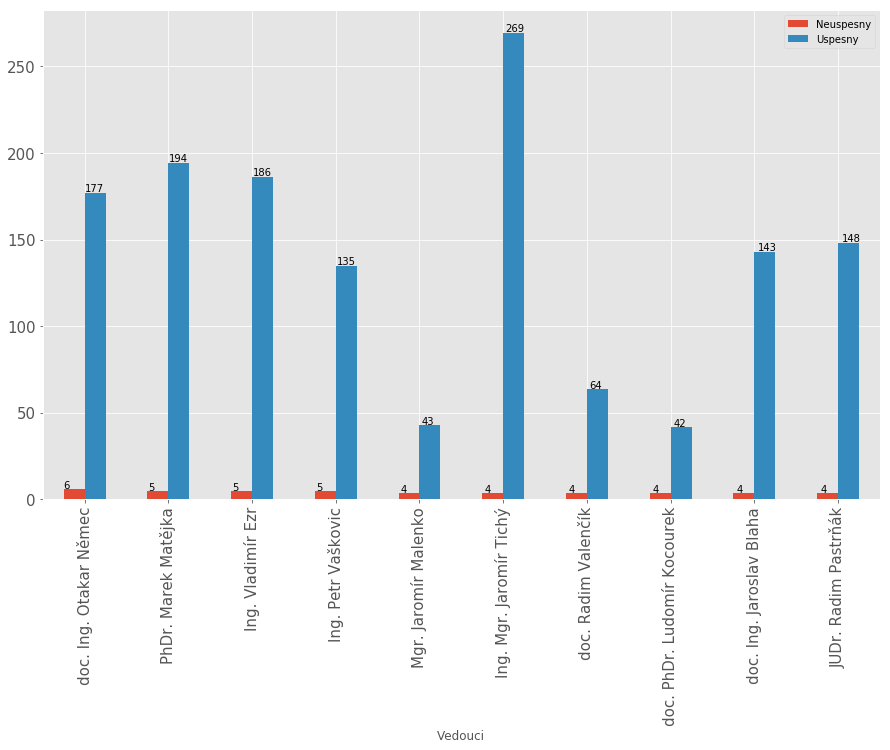

In [18]:
displayDistributionOfBadRightThesis()
displayEvilPerson1('Oponent', 10)
displayEvilPerson1('Vedouci', 10)

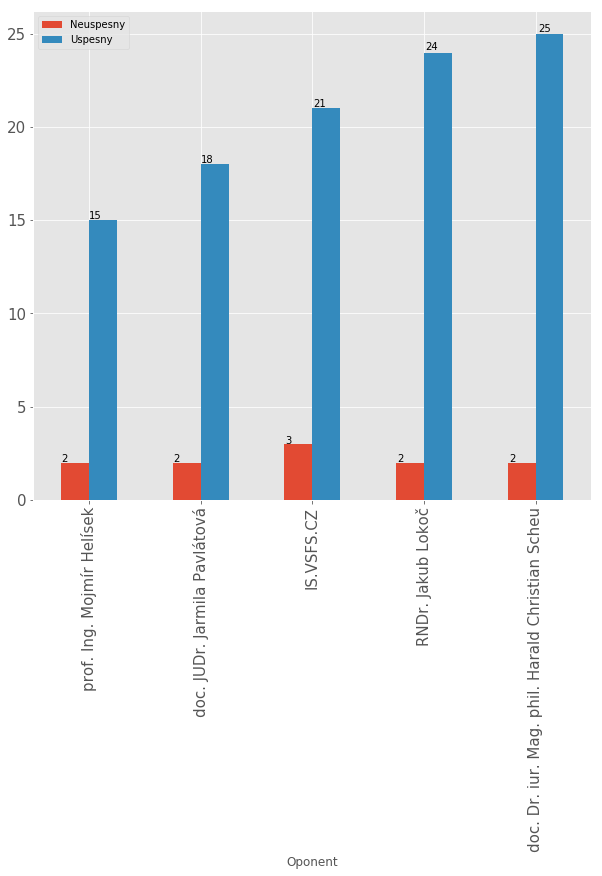

In [19]:
displayEvilPerson2('Oponent', 5)